## Investigate effective redshift distribution for spurious IA signal

In [14]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import locate
import time
import pyccl as ccl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

In [15]:
# paths to required files
data_dir = '/home/b7009348/WGL_project/DES-data/'
lens_file = data_dir+'DES_Y1A1_Lenses_z=0.3-0.45.fits'
source_Zs = data_dir+'mof_BPZ_(stacking).fits'
im3_file_full = data_dir+'y1_im3_shapes_matched.fits'
mcal_file_full = data_dir+'y1_mcal_shapes_matched.fits'

In [17]:
# load in im3 data 
with fits.open(im3_file_full) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    im3_weight = data['weight']
del data

# load in mcal data
with fits.open(mcal_file_full) as hdu:
    data = hdu[1].data
    mcal_weight = data['R11']
del data

# load in z_mc for all sources
with fits.open(source_Zs) as hdu:
    data = hdu[1].data
    source_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
    
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
source_zmc = source_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

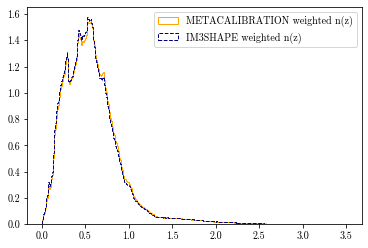

In [18]:
nbins = 500

mcal_counts, mcal_bins = np.histogram(source_zmc, bins=nbins, weights=mcal_weight)
im3_counts, im3_bins = np.histogram(source_zmc, bins=nbins, weights=im3_weight)

plt.figure()
plt.hist(mcal_bins[:-1], mcal_bins, weights=mcal_counts, density=True, histtype='step', color='orange', linestyle='-', linewidth=1)
plt.hist(im3_bins[:-1], im3_bins, weights=im3_counts, density=True, histtype='step', color='navy', linestyle='--', linewidth=1)
plt.legend(labels=('METACALIBRATION weighted n(z)', 'IM3SHAPE weighted n(z)'))
plt.savefig('effective_n(z)_comparison.png', dpi=300)

## Run redshift distributions through CCL pipeline for theoretical $\gamma_{t}$
- Values for cosmology taken from

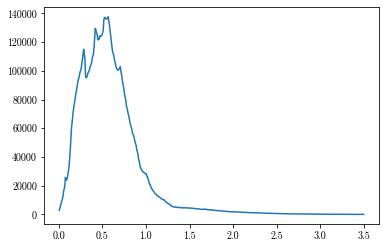

In [21]:
with fits.open(lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    lens_z = data['ZREDMAGIC']
del data

# Define cosmology

cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

mcal_z = mcal_bins[:-1]
mcal_dndz = mcal_counts

im3_z = im3_bins[:-1]
im3_dndz = im3_counts

theta_range = np.linspace(2.5,250,20)

plt.plot(mcal_bins[:-1], mcal_counts)